In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('Darjeeling_daily_10y.csv', skiprows = 1)
print(df)

            Dates  NORMAL (mm)   ACTUAL (mm) 
0     18-Mar-2014           0.9          0.00
1     19-Mar-2014           1.3          2.59
2     20-Mar-2014           1.4          2.81
3     21-Mar-2014           2.0          4.88
4     22-Mar-2014           1.0          0.17
...           ...           ...           ...
3612  14-Mar-2024           0.7          0.28
3613  15-Mar-2024           0.6          0.13
3614  16-Mar-2024           0.8          0.00
3615  17-Mar-2024           2.8          0.06
3616  18-Mar-2024           0.9          0.00

[3617 rows x 3 columns]


In [43]:
print(df.shape)
print("How many NaN are there in the dataset?\n", df.isna().sum())

(3617, 3)
How many NaN are there in the dataset?
 Dates           0
NORMAL (mm)     0
ACTUAL (mm)     0
dtype: int64


In [44]:
Tp = 2894

In [45]:
def plot_train_points(col = 'NORMAL (mm)', Tp = 2894) :

    plt.figure(figsize = (15,4))
    if col == 'NORMAL (mm)':
        plt.title("Rainfall of first {} data points of NORMAL (mm) column".format(Tp), fontsize = 16)
        plt.plot(df['NORMAL (mm)'][:Tp], c = 'k', lw = 1)

    if col == 'ACTUAL (mm)':
        plt.title("Rainfall of first {} data points of ACTUAL (mm) column".format(Tp), fontsize = 16)
        plt.plot(df['ACTUAL (mm)'][:Tp], c = 'k', lw = 1)

    plt.grid(True)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

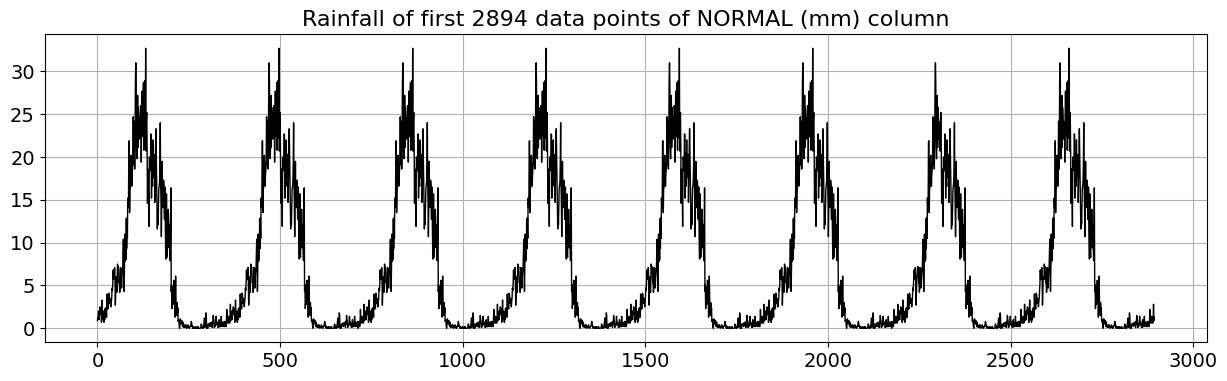

In [46]:
df.columns = df.columns.str.strip()
plot_train_points('NORMAL (mm)')

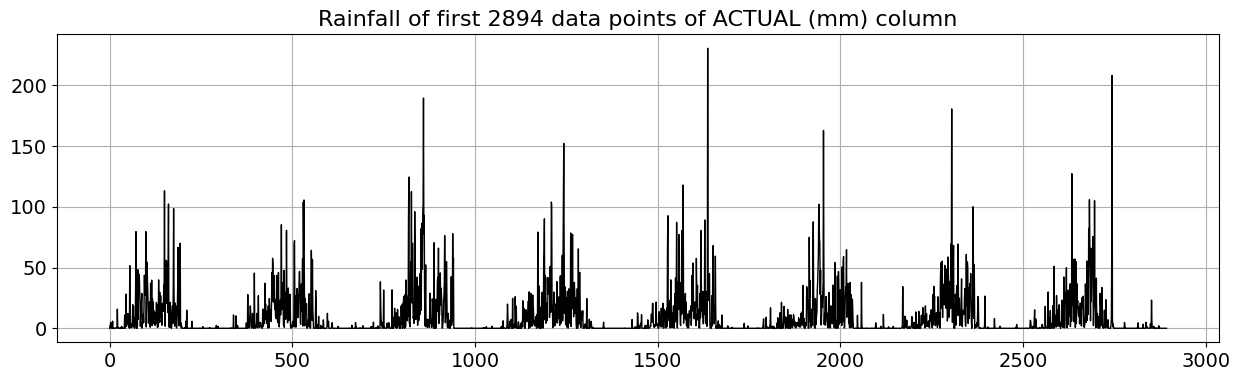

In [47]:
df.columns = df.columns.str.strip()
plot_train_points('ACTUAL (mm)')

In [48]:
train = np.array(df['NORMAL (mm)'][:Tp])
test = np.array(df['NORMAL (mm)'][Tp:])

In [49]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2894,)
Test data length: (723,)


In [50]:
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

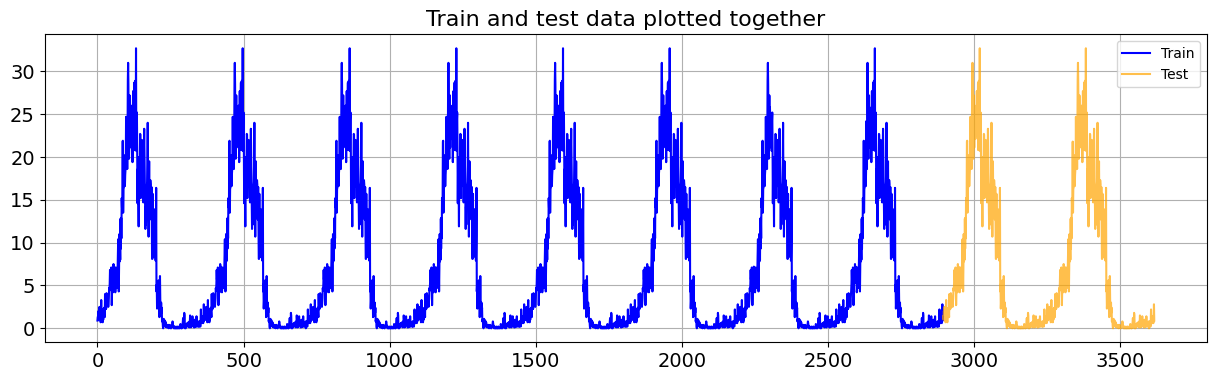

In [51]:
plt.figure(figsize = (15, 4))
plt.title("Train and test data plotted together",fontsize = 16)
plt.plot(np.arange(Tp), train, c = 'blue')
plt.plot(np.arange(Tp, 3617),test, c = 'orange',alpha = 0.7)
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [52]:
step = 10

In [53]:
# add step elements into train and test
test = np.append(test, np.repeat(test[-1,], step))
train = np.append(train, np.repeat(train[-1,], step))

In [54]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2904,)
Test data length: (733,)


In [55]:
def convertToMatrix(data, step) :
    X, Y = [], []

    for i in range(len(data) - step) :
        d = i+step
        X.append(data[i : d, ])
        Y.append(data[d, ])
    
    return np.array(X), np.array(Y)

In [56]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

In [57]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [58]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (2894, 1, 10) ,  (2894,)
Test data shape: (723, 1, 10) ,  (723,)


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [60]:
def build_lstm(num_units = 128, embedding = 4, num_dense = 32, learning_rate = 0.001) :
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of the LSTM layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              learning_rate: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    
    #1st lstm layer with input shape
    model.add(LSTM(units = num_units, input_shape = (1, embedding), activation = "relu", return_sequences = 'True'))

    #2nd lstm layer
    model.add(LSTM(units = num_units, activation = "relu", return_sequences = 'True'))

    #3rd LSTM layer
    model.add(LSTM(units = 50, activation = "relu"))

    #Dense layer
    model.add(Dense(num_dense, activation = "relu"))
    model.add(Dense(1))


    model.compile(loss = 'mean_squared_error', optimizer = RMSprop(learning_rate = learning_rate), metrics = ['mse'])
    
    return model

In [61]:
model_rainfall = build_lstm(num_units = 150, num_dense = 50, embedding = 10, learning_rate = 0.0001)

c:\Users\TATHAGATA GHOSH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model_rainfall.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 150)         │        96,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,001 (1.22 MB)

 Trainable params: 320,001 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs = None) : 
        if (epoch + 1) % 50 == 0 and epoch > 0 :
            print("Epoch number {} done".format(epoch + 1))

In [64]:
#Batch size and number of epochs
batch_size = 16
num_epochs = 1000

In [65]:
model_rainfall.fit(trainX,trainY, 
          epochs = num_epochs, 
          batch_size = batch_size, 
          callbacks=[MyCallback()], verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


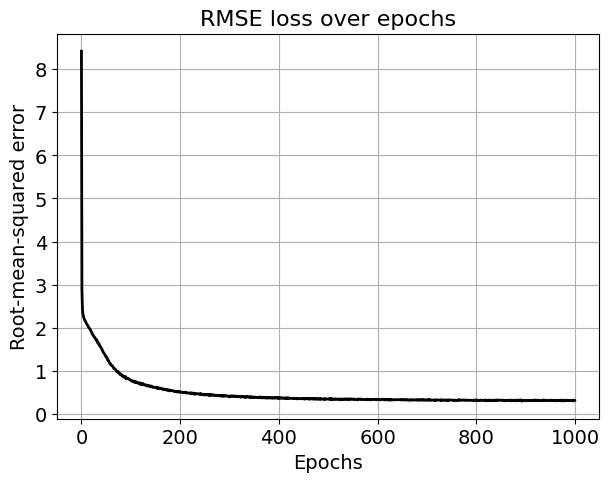

In [66]:
plt.figure(figsize = (7,5))
plt.title("RMSE loss over epochs",fontsize = 16)
plt.plot(np.sqrt(model_rainfall.history.history['loss']), c = 'k', lw = 2)
plt.grid(True)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Root-mean-squared error",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

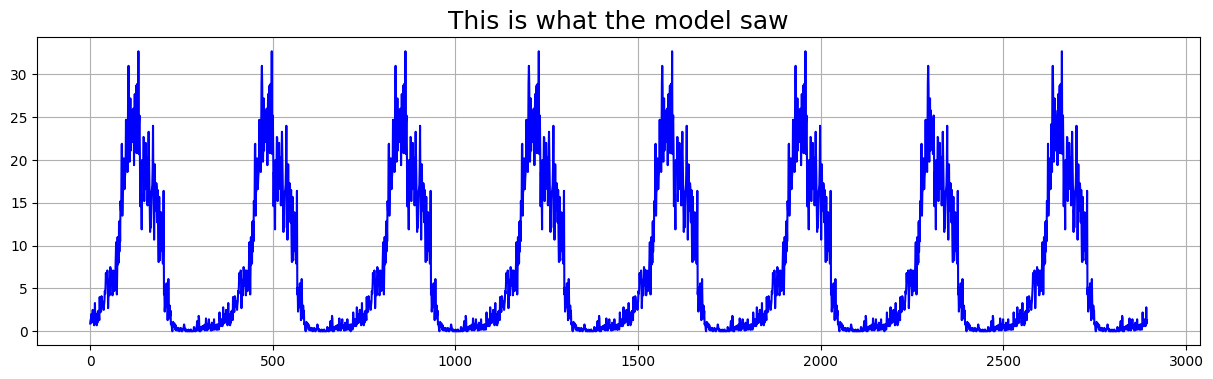

In [67]:
plt.figure(figsize = (15, 4))
plt.title("This is what the model saw", fontsize = 18)
plt.plot(trainX[:, 0][:, 0], c = 'blue')
plt.grid(True)
plt.show()

In [68]:
trainPredict = model_rainfall.predict(trainX)
testPredict = model_rainfall.predict(testX)
predicted = np.concatenate((trainPredict,testPredict), axis = 0)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


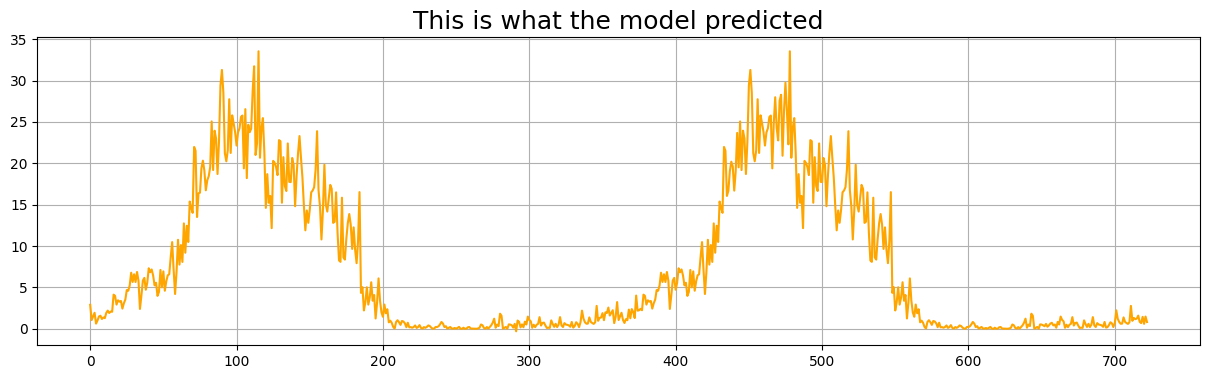

In [69]:
plt.figure(figsize = (15, 4))
plt.title("This is what the model predicted", fontsize = 18)
plt.plot(testPredict, c = 'orange')
plt.grid(True)
plt.show()

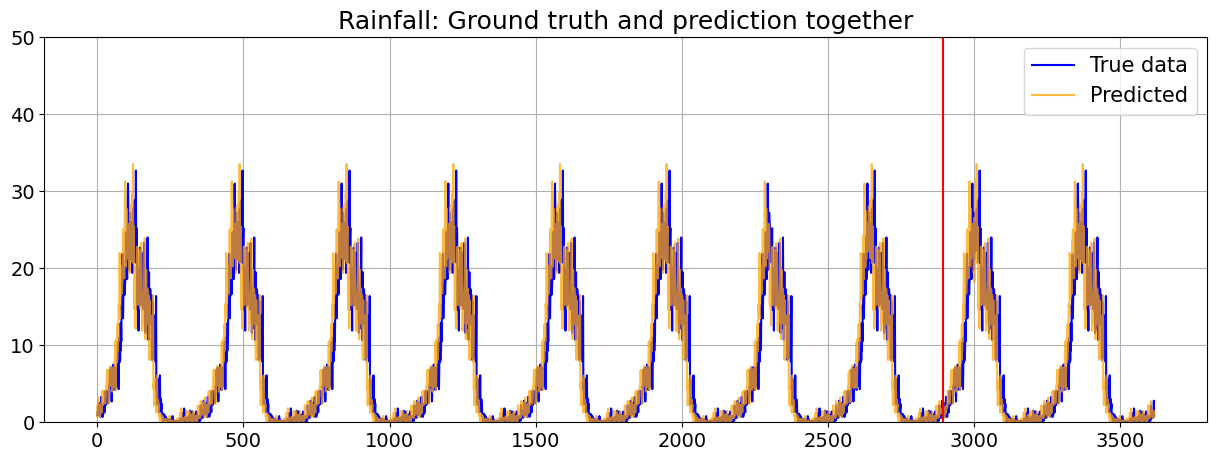

In [71]:
index = df.index.values

plt.figure(figsize = (15, 5))
plt.title("Rainfall: Ground truth and prediction together", fontsize = 18)
plt.plot(index, df['NORMAL (mm)'], c = 'blue')
plt.plot(index, predicted, c = 'orange', alpha = 0.75)
plt.legend(['True data','Predicted'], fontsize = 15)
plt.axvline(x = Tp, c = "r")
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(0, 50)
plt.show()

In [72]:
# Define Tp and N
Tp = 2984  # Assign appropriate value
N = 3617  # Define the upper limit for the index

# Ensure predicted and df['NORMAL (mm)'] values are reshaped correctly
predicted_values = predicted[Tp : N].reshape(-1)
actual_values = df['NORMAL (mm)'][Tp : N].values.reshape(-1)

# Calculate the errors
error = predicted_values - actual_values

# Flatten the error array if necessary
error = np.array(error).ravel()

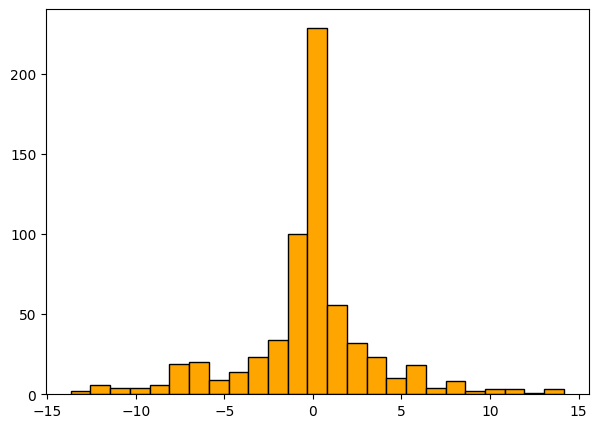

In [73]:
plt.figure(figsize = (7,5))
plt.hist(error, bins = 25, edgecolor = 'k', color = 'orange')
plt.show()

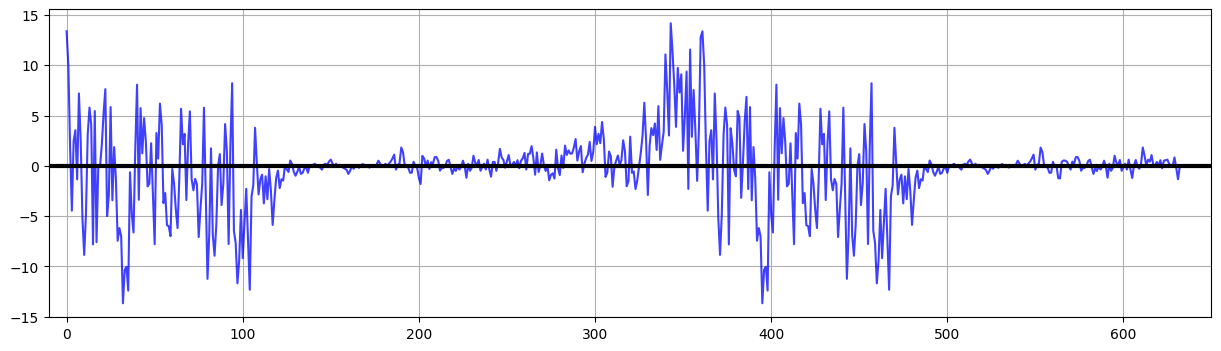

In [78]:
plt.figure(figsize = (15, 4))
plt.plot(error,c = 'blue', alpha = 0.75)
plt.hlines(y = 0, xmin = -10, xmax = 650, color = 'k', lw = 3)
plt.xlim(-10, 650)
plt.grid(True)
plt.show()

In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score, mean_absolute_percentage_error as MAPE

# Assume testX and testY are already scaled appropriately
predicted = model_rainfall.predict(testX)

# Evaluate the model using the scaled values directly
mse = MSE(testY, predicted)
rmse = np.sqrt(mse)
mae = MAE(testY, predicted)
r2 = r2_score(testY, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.4132936736385965
Root Mean Squared Error (RMSE): 0.6428792061022012
Mean Absolute Error (MAE): 0.17274215464399065
R-squared (R2): 0.9944794045018596
